In [1]:
pip install -U lightautoml

     |████████████████████████████████| 250 kB 2.8 MB/s 
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
     |████████████████████████████████| 204 kB 12.4 MB/s 
     |████████████████████████████████| 424 kB 11.9 MB/s 
     |████████████████████████████████| 232 kB 13.7 MB/s 
     |████████████████████████████████| 2.8 MB 13.5 MB/s 
     |████████████████████████████████| 548 kB 26.2 MB/s 
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 90 kB 5.9 MB/s 
     |████████████████████████████████| 89 kB 5.3 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 96 kB 3.9 MB/s 
     |████████████████████████████████| 121 kB 27.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=34c1fabce77824ca7fac5c2a39c330d9f69ca35ef4c0dded0f423c6dac94c0f3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58c

# Step 0.1. Import necessary libraries 

In [2]:
# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

# Step 0.2. Parameters 

In [3]:
N_THREADS = 8# threads cnt for lgbm and linear models
N_FOLDS = 7 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 5 * 3600 # Time in seconds for automl run
TARGET_NAME = 'target'

# Step 0.3. Data load 

In [4]:
%%time

train_data = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
train_data[TARGET_NAME] = train_data[TARGET_NAME].str.slice(start=6).astype(int) - 1
train_data.head()

CPU times: user 347 ms, sys: 43.1 ms, total: 390 ms
Wall time: 517 ms


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,1
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,0
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,3
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [5]:
test_data = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
test_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


In [6]:
submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')
submission.head()

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.25,0.25,0.25,0.25
1,100001,0.25,0.25,0.25,0.25
2,100002,0.25,0.25,0.25,0.25
3,100003,0.25,0.25,0.25,0.25
4,100004,0.25,0.25,0.25,0.25


# Step 0.5. Add new features

In [7]:
def create_gr_feats(data):
#     feature_cols = [col for col in data.columns if col.startswith('feature')]
#     data['All_features_sum'] = data[feature_cols].sum(axis = 1)
#     data['All_features_zeros_cnt'] = (data[feature_cols] == 0).sum(axis = 1)
    pass
    

all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
create_gr_feats(all_df)
train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
print(train_data.shape, test_data.shape)

(100000, 52) (50000, 52)


In [8]:
train_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,1.0
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,0.0
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,3.0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0


# ========= AutoML preset usage =========


## Step 1. Create Task

In [9]:
%%time

task = Task('multiclass',)

CPU times: user 2.26 ms, sys: 1.9 ms, total: 4.16 ms
Wall time: 3.55 ms


## Step 2. Setup columns roles

In [10]:
%%time

roles = {
    'target': TARGET_NAME,
    'drop': ['id'],
}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


## Step 3. Train on full data 

In [11]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS},
                               configs_list=[
                                   '../input/lightautoml-configs/conf_4_sel_type_0_no_int.yml',
                                   '../input/lightautoml-configs/conf_5_sel_type_1_tuning_full.yml',
                                   '../input/lightautoml-configs/conf_6_sel_type_1_tuning_full_no_int_lgbm.yml'
                               ])
oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'random_state': 42}
Start automl preset with listed constraints:
- time: 17999.99676465988 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (100000, 52)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 17964.084817171097 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -1.1129304492264986
Linear model: C = 5e-05 score = -1.10894646223709
Linear model: C = 0.0001 score = -1.108363900347799
Linear model: C = 0.0005 score = -1.108388671990484
Linear model: C = 0.001 score = -1.1084982758805155

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -1.1124132260903716
Linea

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's multi_logloss: 1.09969
[200]	valid's multi_logloss: 1.09874
[300]	valid's multi_logloss: 1.10109
Early stopping, best iteration is:
[167]	valid's multi_logloss: 1.09846
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's multi_logloss: 1.09915
[200]	valid's multi_logloss: 1.09679
[300]	valid's multi_logloss: 1.09856
Early stopping, best iteration is:
[190]	valid's multi_logloss: 1.0967
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores do

CPU times: user 166 ms, sys: 5.06 ms, total: 171 ms
Wall time: 181 ms


<AxesSubplot:xlabel='Feature'>

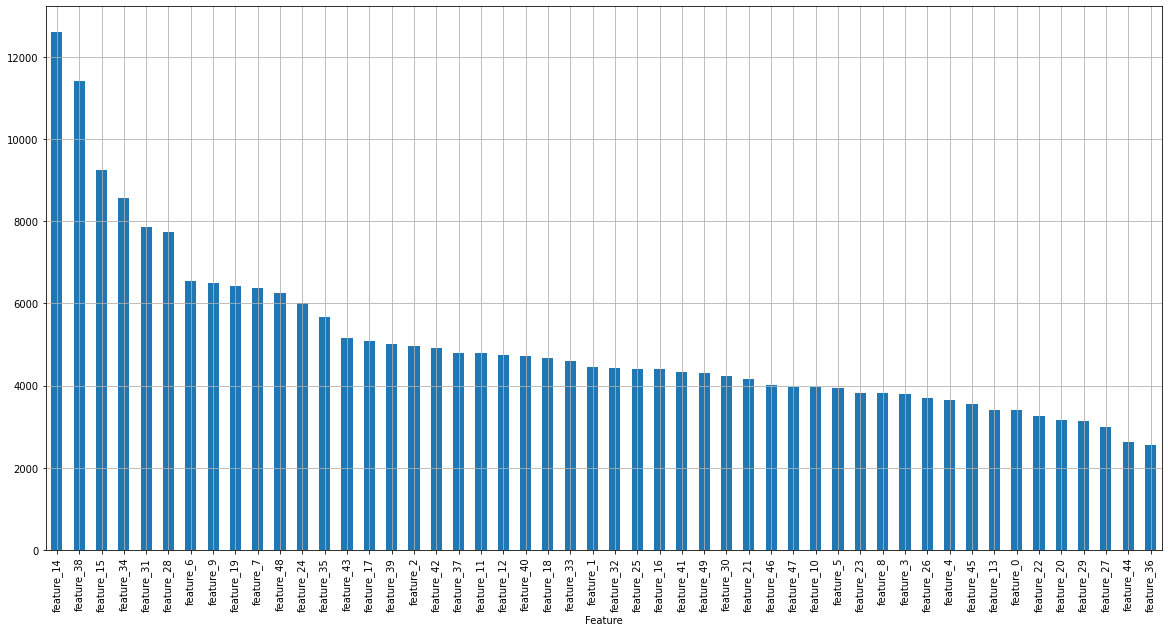

In [12]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Predict for test data and check OOF score

In [13]:
%%time

test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))

Prediction for test data:
array([[0.09221984, 0.6244182 , 0.16913097, 0.11423104],
       [0.09495565, 0.6908981 , 0.12911114, 0.08503512],
       [0.08269265, 0.64477533, 0.17159066, 0.10094145],
       [0.08985905, 0.5359255 , 0.27489787, 0.09931767],
       [0.07836558, 0.6273017 , 0.18547116, 0.10886157],
       [0.08199541, 0.44024244, 0.3480277 , 0.12973452],
       [0.10080127, 0.33341542, 0.45092064, 0.11486274],
       [0.0972897 , 0.72891575, 0.10579462, 0.06799999],
       [0.0901527 , 0.5866557 , 0.22125979, 0.10193188],
       [0.08547328, 0.54980165, 0.22869162, 0.13603349]], dtype=float32)
Shape = (50000, 4)
Check scores...
OOF score: 1.0859478292870521
CPU times: user 11min 45s, sys: 605 ms, total: 11min 46s
Wall time: 3min 13s


## Step 5. Prepare submission

In [14]:
submission.iloc[:, 1:] = test_pred.data
submission.to_csv('Submission.csv', index = False)

In [15]:
submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.092220,0.624418,0.169131,0.114231
1,100001,0.094956,0.690898,0.129111,0.085035
2,100002,0.082693,0.644775,0.171591,0.100941
3,100003,0.089859,0.535926,0.274898,0.099318
4,100004,0.078366,0.627302,0.185471,0.108862
...,...,...,...,...,...
49995,149995,0.099851,0.693048,0.138960,0.068141
49996,149996,0.085069,0.648677,0.130564,0.135691
49997,149997,0.074823,0.541202,0.221457,0.162519
49998,149998,0.080014,0.599371,0.160854,0.159760
